# Spectral Plots

Notes
- some lines when too close are not labeled (minLineSep)
- TOOD: x1 and x2 are not the same, but shifted so might need to interpolate? Check shifting carefully
- consistent colors for kronos and krios across *all* plots

In [1]:
import palettable

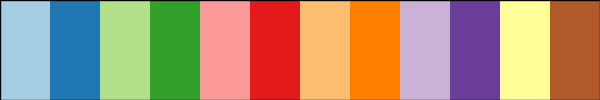

In [2]:
palettable.colorbrewer.qualitative.Paired_12.show_discrete_image()

In [3]:
from __future__ import division # to get float division with ints

# Import readsav so we can read IDL Save Files
import warnings
from scipy.io import readsav
warnings.filterwarnings('ignore', message="warning: empty strings")

import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import re

In [4]:
plt.style.use('notebook.mplstyle')

In [5]:
import specplot

In [24]:
import importlib
importlib.reload(specplot)

<module 'specplot' from '/Users/semyeong/projects/CronusCrius/notebooks/specplot.py'>

In [25]:
krios = specplot.SpecPlot('../data/240429_rj211.86/iter1_abund.out')
kronos = specplot.SpecPlot('../data/240430_rj211.85/iter1_abund.out')

In [7]:
krios.spec.wave[0][0], krios.spec.wave[0][-1]

(5164.0173715227829, 7798.976834797988)

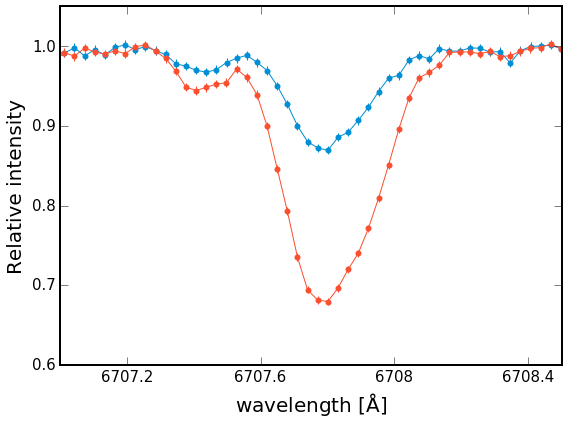

In [34]:
plt.figure(figsize=(8,6))
plt.errorbar(krios.spec.wave[0], krios.spec.sob[0], yerr=krios.spec.uob[0], fmt='o-')
plt.errorbar(kronos.spec.wave[0], kronos.spec.sob[0], yerr=kronos.spec.uob[0], fmt='o-')
plt.xlim(6707,6708.5)
plt.ylim(0.6,1.05)
plt.xticks([6707.2, 6707.6, 6708, 6708.4], [str(x) for x in [6707.2, 6707.6, 6708, 6708.4]])
plt.xlabel('wavelength [$\AA$]')
plt.ylabel('Relative intensity')
plt.tight_layout()
plt.savefig('lithium.png')

In [7]:
segIdx = krios.getGoodSegs('Na')
markLines = krios.getLinesToMark(10, ['Na 1', 'Fe 1', 'Si 1', 'Ca 1'], minDepth=0)

In [8]:
seg, wrange, elems = 9, (6154.22-0.5, 6154.22+2), ['Na 1', 'Fe 1', 'Si 1', 'Ca 1']
seg, wrange, elems = 10, (6160.7487-0.5, 6161.7), ['Na 1', 'Fe 1', 'Si 1', 'Ca 1']

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame()
df['species'] = [s.decode() for s in krios.spec.species[0]]
df['depth'] = krios.spec.depth[0]
df['wave'] = krios.spec.atomic[0][:,2]

In [11]:
def get_segidx(wave):
    idx = np.where((krios.wran[:,0] <= wave) & (wave <= krios.wran[:,1]))[0]
    if idx.size == 0:
        return -1
    return idx[0]
segidx = list(map(get_segidx, df.wave))
df['segidx'] = segidx

In [12]:
elements = ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'Ca',
            'Ti', 'V', 'Cr', 'Mn', 'Ni', 'Y']

In [17]:
df['elem'] = df.species.str.extract('([a-zA-z0-9]+) [1-9]')
print(df.elem.describe())

count     7555
unique      65
top         CN
freq      1369
Name: elem, dtype: object


/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [18]:
in_catalog = np.array([elem in elements for elem in df.elem])

In [19]:
df_in_catalog = df.loc[in_catalog]

In [20]:
df_in_catalog.loc[df_in_catalog.depth>0.25].elem.value_counts()

Ti    43
Ni    41
Cr    38
V     32
Ca    14
Mn    11
Si     9
Mg     6
O      3
Y      3
Al     2
Na     2
Name: elem, dtype: int64

In [19]:
df.loc[(df.segidx == 0) & (df.depth>0.25) & in_catalog].sort_values('depth').species.values

array(['V 1', 'Cr 1', 'Ti 1', 'V 1', 'Ni 1', 'Cr 1', 'Cr 1', 'Ti 1', 'V 1',
       'V 1', 'V 1', 'Ti 1', 'Cr 2', 'Cr 1', 'Ni 1', 'Ni 1', 'Ni 1',
       'Ti 1', 'Cr 1', 'Ni 1', 'Ni 1', 'Ca 1', 'Ni 1', 'Ti 2', 'Ti 2',
       'Ti 2', 'Ti 1', 'Mg 1', 'Mg 1', 'Mg 1'], dtype=object)

In [ ]:
4, [6016.67-1, 6016.67+1], ['Mn 1', 'Fe 1']

In [22]:
krios_model_color = '#1F78B4'
krios_data_color = '#A6CEE3'
kronos_model_color = '#E31A1C'
kronos_data_color = '#FB9A99'


def plotKKSpec(ax, seg, wrange, elems, minDepth=0.25, labely=True):
    from matplotlib.ticker import MaxNLocator
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    if len(elems)>0:
        markLines=krios.getLinesToMark(seg, elems, minDepth=minDepth)
    else:
        markLines = []

    krios.plotSeg(seg, wrange, showLines=markLines, ax=ax, labelSpeciesOnly=True,
                  modColor=krios_model_color, obsColor=krios_data_color,
                  modWidth=1);
    kronos.plotSeg(seg, wrange, showLines=markLines, ax=ax, labelSpeciesOnly=True,
                   modColor=kronos_model_color, obsColor=kronos_data_color,
                   modWidth=1);

    divider = make_axes_locatable(ax)
    ax_diff = divider.new_vertical(size="100%", pad=0.1, pack_start=True)
    fig.add_axes(ax_diff)
    # TODO: x1 and x2 are not the same, but shifted so might need to interpolate?
    x1, y1 = krios.lineObs.get_data()
    x2, y2 = kronos.lineObs.get_data()
    xm1, ym1 = krios.lineModel.get_data()
    xm2, ym2 = kronos.lineModel.get_data()
    # ax_diff.plot(x1, y2-y1, 'k.-', xm1, ym2-ym1, 'b-')
    ax_diff.plot(x1, y2/y1, '-', color='#999999', lw=2)
    ax_diff.plot(xm1, ym2/ym1, 'k-', lw=1)
    ax_diff.axhline(0, ls='-', c='k', zorder=-50)
    ax.set_xticklabels([])
    ax_diff.set_xlim(ax.get_xlim())
    ax_diff.get_xaxis().get_major_formatter().set_useOffset(False)
    ax_diff.set_ylim(0.8,1.1)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower'))
    ax_diff.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower'))
    if labely:
        ax.set_ylabel('Intensity', size=15)
        ylb = ax_diff.set_ylabel('Ratio', size=15)
    return ax, ax_diff

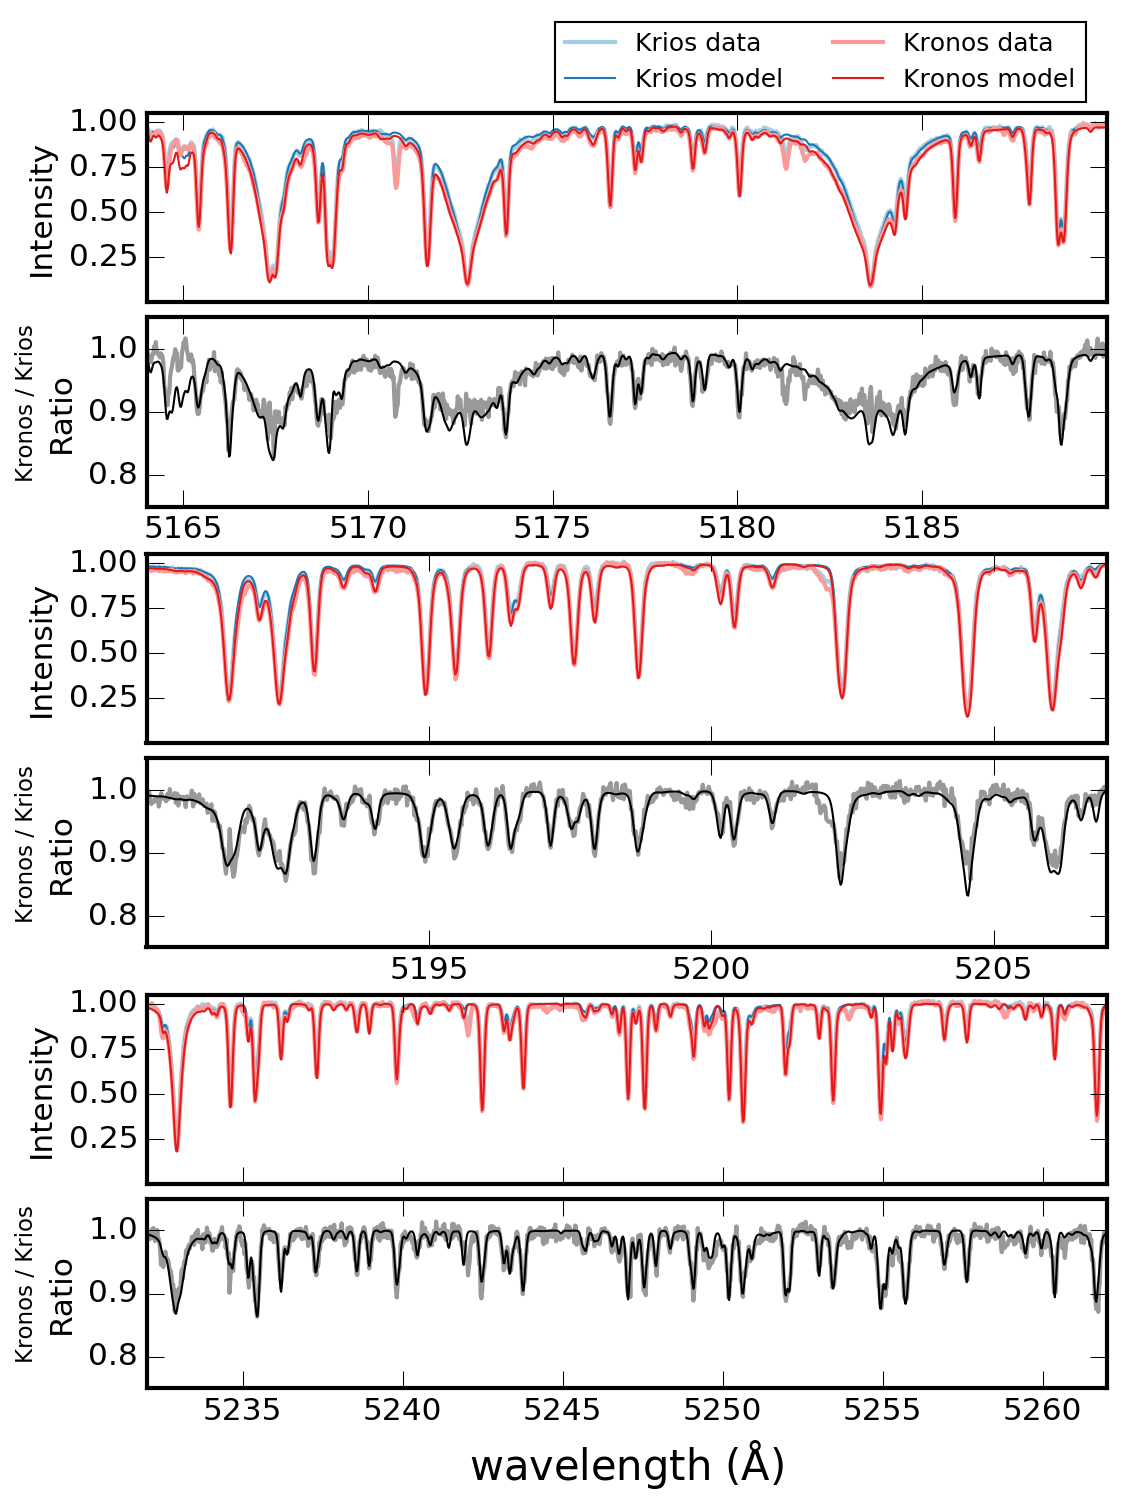

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(8,10), dpi=150)
fig.subplots_adjust(bottom=0.07, left=0.15, top=0.92, right=0.95, hspace=0.12)

elems = df.loc[(df.segidx == 9) & (df.depth>0.5) & (in_catalog)].sort_values('depth').species.values

cax0, cax_diff = plotKKSpec(ax[0], 0, krios.wran[0], [])
list(map(lambda x: x.set_xticks([5165, 5170, 5175, 5180, 5185]), [cax0, cax_diff]));
cax_diff.text(-0.125, 0.55, "Kronos / Krios", transform=cax_diff.transAxes,
             va='center', ha='center', rotation=90, size=11)
cax_diff.set_yticks([0.8, 0.9, 1.,])
cax_diff.set_ylim([0.75, 1.05])

cax, cax_diff = plotKKSpec(ax[1], 1, krios.wran[1], [])
list(map(lambda x: x.set_xticks([5195, 5200, 5205]), [cax, cax_diff]));
cax_diff.text(-0.125, 0.55, "Kronos / Krios", transform=cax_diff.transAxes,
             va='center', ha='center', rotation=90, size=11)
cax_diff.set_yticks([0.8, 0.9, 1.,])
cax_diff.set_ylim([0.75, 1.05])

cax, cax_diff = plotKKSpec(ax[2], 2, krios.wran[2], [])
cax_diff.text(-0.125, 0.55, "Kronos / Krios", transform=cax_diff.transAxes,
             va='center', ha='center', rotation=90, size=11)
cax_diff.set_yticks([0.8, 0.9, 1.,])
cax_diff.set_ylim([0.75, 1.05])

cax_diff.set_xlabel('wavelength ($\AA$)')
# fig.text(0.05, 0.55, "Residual intensity (ratio)",
#          rotation=90, va='center', ha='center', size=25)

handles=[
    plt.Line2D([],[], linewidth=2, color=krios_data_color),
    plt.Line2D([],[], linewidth=1, color=krios_model_color),
    plt.Line2D([],[], linewidth=2, color=kronos_data_color),
    plt.Line2D([],[], linewidth=1, color=kronos_model_color)]
fig.legend(handles, ['Krios data', 'Krios model', 'Kronos data', 'Kronos model'],
           loc=(0.495, 0.932), ncol=2,
          )

fig.savefig('../paper/figures/spec1.pdf')

In [ ]:
df.loc[(df.segidx == 4) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.values

In [ ]:
from matplotlib.ticker import MaxNLocator

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)
elems = df.loc[(df.segidx == 4) & (df.depth>0.25) & (in_catalog)].species.unique()
elems = df.loc[(df.segidx == 4) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.unique()
cax, cax_diff = plotKKSpec(ax, 4, [6015.7,6024.5], ['Mn 1', 'Fe 1'], minDepth=0.1)
cax.xaxis.set_major_locator(MaxNLocator(2))

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
elems = df.loc[(df.segidx == 8) & (df.depth>0.25) & (in_catalog)].species.unique()
elems = df.loc[(df.segidx == 8) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.values
cax, cax_diff = plotKKSpec(ax, 8, [6121,6124], elems)
cax.set_ylim(cax.get_ylim()[0], 1.7)
cax_diff.xaxis.set_major_locator(MaxNLocator(2))

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

elems = df.loc[(df.segidx == 9) & (df.depth>0.5) & ((in_catalog)|(df.species=='Fe 1'))].species.values
cax, cax_diff = plotKKSpec(ax, 9, [6153, 6157], elems)
cax_diff.xaxis.set_major_locator(MaxNLocator(2))

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

elems = df.loc[(df.segidx == 14) & (df.depth>0.5) & ((in_catalog)|(df.species=='Fe 1'))].species.values
cax, cax_diff = plotKKSpec(ax, 9, [6153, 6157], elems)
cax_diff.xaxis.set_major_locator(MaxNLocator(2))

In [ ]:
plt.plot(krios.spec.wave[0])

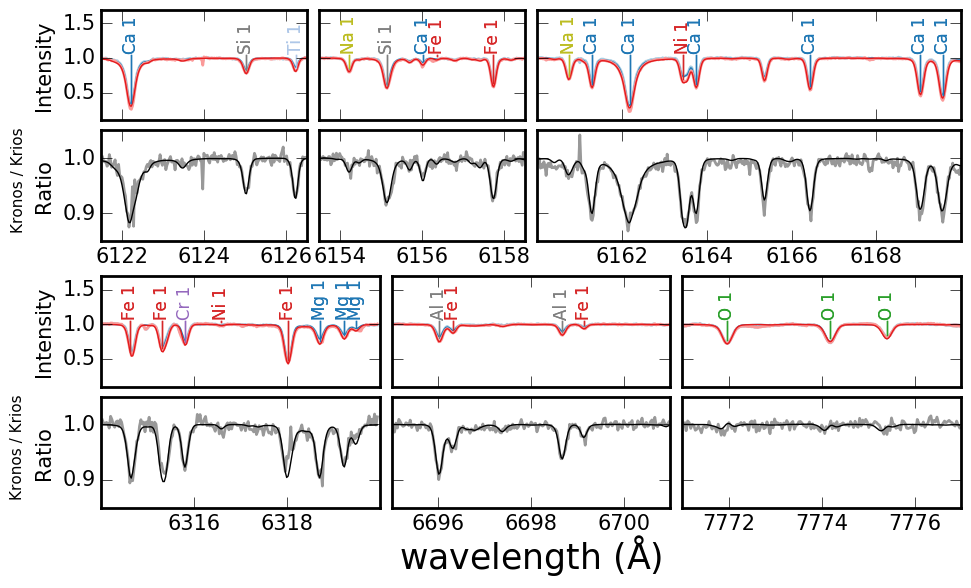

In [34]:
style = {
    'xtick.labelsize' : 15,
    'ytick.labelsize' : 15
}

with plt.style.context(style):
    fig = plt.figure(figsize=(10,6), dpi=100)
    fig.subplots_adjust(bottom=0.13, left=0.12, top=0.96, right=0.98, hspace=0.15)

    # First row
    ax = plt.subplot2grid((2, 12), (0, 0), colspan=3)
    elems = df.loc[(df.segidx == 8) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.values
    cax, cax_diff = plotKKSpec(ax, 8, [6121.5,6126.5], elems, labely=True)
    cax.set_yticks([0.5, 1., 1.5])
    cax.set_ylim([0.1, 1.7])
    cax_diff.set_yticks([0.8, 0.9, 1.,])
    cax_diff.set_ylim([0.85, 1.05])
    list(map(lambda x: x.set_xticks([6122, 6124, 6126]), [cax, cax_diff]));
    cax_diff.text(-0.4, 0.55, "Kronos / Krios", transform=cax_diff.transAxes,
                  va='center', ha='center', rotation=90, size=11)
    
    ax = plt.subplot2grid((2, 12), (0, 3), colspan=3)
    elems = df.loc[(df.segidx == 9) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.values
    cax, cax_diff = plotKKSpec(ax, 9, [6153.5, 6158.5], elems, labely=False)
    cax.set_yticks([0.5, 1., 1.5])
    cax.set_ylim([0.1, 1.7])
    cax_diff.set_yticks([0.8, 0.9, 1.,])
    cax_diff.set_ylim([0.85, 1.05])
    list(map(lambda x: x.set_xticks([6154, 6156, 6158]), [cax, cax_diff]));
    list(map(lambda x: x.set_yticklabels([]), [cax, cax_diff]));

    ax = plt.subplot2grid((2, 12), (0, 6), colspan=6)
    elems = df.loc[(df.segidx == 10) & (df.depth>0.25) & ((in_catalog))].species.unique()
    cax, cax_diff = plotKKSpec(ax, 10, [6160, 6170], elems, labely=False)
    cax.set_yticks([0.5, 1., 1.5])
    cax.set_ylim([0.1, 1.7])
    cax_diff.set_yticks([0.8, 0.9, 1.,])
    cax_diff.set_ylim([0.85, 1.05])
    list(map(lambda x: x.set_xticks([6162, 6164, 6166, 6168]), [cax, cax_diff]));
    list(map(lambda x: x.set_yticklabels([]), [cax, cax_diff]));

    # Second row
    ax = plt.subplot2grid((2, 12), (1, 0), colspan=4)
    elems = df.loc[(df.segidx == 12) & (df.depth>0.5) & ((in_catalog)|(df.species=='Fe 1'))].species.unique()
    cax, cax_diff = plotKKSpec(ax, 12, [6314, 6320], elems, labely=True)
    # delete some labels by hand....
    del cax.texts[-6]
    cax.set_yticks([0.5, 1., 1.5])
    cax.set_ylim([0.1, 1.7])
    cax_diff.set_yticks([0.8, 0.9, 1.,])
    cax_diff.set_ylim([0.85, 1.05])
    list(map(lambda x: x.set_xticks([6316, 6318]), [cax, cax_diff]));
    cax_diff.text(-0.3, 0.55, "Kronos / Krios", transform=cax_diff.transAxes,
                  va='center', ha='center', rotation=90, size=11)
    
    ax = plt.subplot2grid((2, 12), (1, 4), colspan=4)
    seg, wrange = 14, [6695., 6701]
    elems = df.loc[(df.segidx == seg) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.unique()
    cax, cax_diff = plotKKSpec(ax, seg, wrange, elems, labely=False)
    cax.set_yticks([0.5, 1., 1.5])
    cax.set_ylim([0.1, 1.7])
    cax_diff.set_yticks([0.8, 0.9, 1.,])
    cax_diff.set_ylim([0.85, 1.05])
    list(map(lambda x: x.set_xticks([6696, 6698, 6700]), [cax, cax_diff]));
    list(map(lambda x: x.set_yticklabels([]), [cax, cax_diff]));

#     ax = plt.subplot2grid((2, 12), (1, 6), colspan=3)
#     seg, wrange = 15, [6707,6709]
#     elems = df.loc[(df.segidx == seg) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.unique()
#     cax, cax_diff = plotKKSpec(ax, seg, wrange, elems, labely=False)
#     cax.set_yticks([0.5, 1., 1.5])
#     cax.set_ylim([0.1, 1.7])
#     cax_diff.set_yticks([0.8, 0.9, 1.,])
#     cax_diff.set_ylim([0.75, 1.05])
#     list(map(lambda x: x.set_xticks([6707.5, 6708.5]), [cax, cax_diff]));
#     list(map(lambda x: x.set_yticklabels([]), [cax, cax_diff]));
#     # Label Li I
#     li_color = '#9467BD'  # purple from tableau palette
#     ax.annotate('Li I', (6707.8, 0.7), (6707.8, 1.3),  textcoords='data',
#                 ha='center', rotation=90, arrowprops=dict(arrowstyle='-', linewidth=1, color=li_color),
#                 color=li_color, fontsize=12, weight='bold')

    ax = plt.subplot2grid((2, 12), (1, 8), colspan=4)
    seg, wrange = 19, [7771, 7777]
    elems = df.loc[(df.segidx == seg) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.unique()
    cax, cax_diff = plotKKSpec(ax, seg, wrange, elems, labely=False)
    cax.set_yticks([0.5, 1., 1.5])
    cax.set_ylim([0.1, 1.7])
    cax_diff.set_yticks([0.8, 0.9, 1.,])
    cax_diff.set_ylim([0.85, 1.05])
    list(map(lambda x: x.set_xticks([7772, 7774, 7776]), [cax, cax_diff]));
    list(map(lambda x: x.set_yticklabels([]), [cax, cax_diff]));

    fig.text(0.55, 0.05, "wavelength ($\AA$)",
             va='center', ha='center', size=25)
    
    plt.draw()

    fig.savefig('../paper/figures/spec2.pdf')

## Lithium

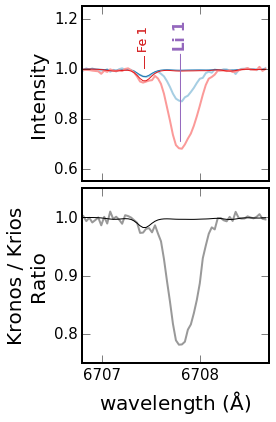

In [71]:
# ax = plt.subplot2grid((2, 12), (1, 6), colspan=3)
with plt.style.context(style):
    fig, ax = plt.subplots(figsize=(4,6))
    fig.subplots_adjust(top=0.95, right=0.95, left=0.3)
    seg, wrange = 15, [6706.8,6708.7]
    elems = df.loc[(df.segidx == seg) & (df.depth>0.25) & ((in_catalog)|(df.species=='Fe 1'))].species.unique()
    cax, cax_diff = plotKKSpec(ax, seg, wrange, elems, labely=False)
    cax.set_yticks([0.6, 0.8, 1., 1.2])
    cax.set_ylim([0.55, 1.25])
    cax_diff.set_yticks([0.8, 0.9, 1.,])
    cax_diff.set_ylim([0.75, 1.05])
    list(map(lambda x: x.set_xticks([6707., 6708.,]), [cax, cax_diff]));
#     list(map(lambda x: x.set_yticklabels([]), [cax, cax_diff]));
    cax_diff.set_xlabel("wavelength ($\AA$)")
    cax.set_ylabel('Intensity')
    cax_diff.set_ylabel('Kronos / Krios\nRatio')
    # Label Li I
    li_color = '#9467BD'  # purple from tableau palette
    ax.annotate('Li 1', (6707.8, 0.7), (6707.8, 1.15),  textcoords='data',
                ha='center', rotation=90, arrowprops=dict(arrowstyle='-', linewidth=1, color=li_color),
                color=li_color, fontsize=15, weight='bold')
    fig.savefig('../paper/figures/spec_lithium.pdf')